# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
%matplotlib inline
import datetime
import os
import pandas as pd
import numpy as np

In [2]:
DATA_FOLDER = os.path.join('.', 'Data') # Use the data folder provided in Tutorial 02 - Intro to Pandas.

# Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

## Helper functions for analysing the data in different datasets

In [3]:
def compute_columns_series(dataframe_list):
    """Function that computes the series representing the concatenation of the columns for each dataset of a specific country."""
    
    if len(dataframe_list) == 0 :
        return None
    
    return pd.Series([column for dataframe in dataframe_list for column in dataframe.columns.values])

In [4]:
def compute_desired_column_series(dataframe_list, desired_column):
    """ Function that computes the values in the column desired_column for all the datasets of a specific country. """
    
    if len(dataframe_list) == 0 :
        return None
    
    values_list = [description for dataframe in dataframe_list for description in dataframe[desired_column].values]
    return pd.Series(values_list)

In [5]:
def load_country_data(country_folder, date_column, thousands_parse=False):
    """Function that loads all the datasets for a specific country. Returns a list of DataFrame structures, each one of them for
    a file under the folder defined by country_folder. """
    
    results = [] # a list with the data frames for each file
    COUNTRY_FOLDER = os.path.join(DATA_FOLDER, 'ebola', country_folder)
    
    for filename in os.listdir(COUNTRY_FOLDER):
        file = os.path.join(COUNTRY_FOLDER, filename)
        
        if not thousands_parse:
            current_dataframe = pd.read_csv(file, index_col=[date_column], parse_dates=[date_column])
        else:
            current_dataframe = pd.read_csv(file, index_col=[date_column], thousands=',', na_values=['-'])
        results.append(current_dataframe)
    
    return results

### Guinea Dataset

In [6]:
guinea_dataframes = load_country_data('guinea_data', 'Date') # Loading the Guinea data

###  Guinea dataset transformation

As we can see below, the columns of the files are mostly the same, with some files having more cities as a breakdown than others. As we will argue later, this doesn't represent an inconvenient for our task.

In [7]:
compute_columns_series(guinea_dataframes).value_counts()

Dinguiraye     22
Totals         22
Conakry        22
Boffa          22
Siguiri        22
Dabola         22
Macenta        22
Pita           22
Kissidougou    22
Description    22
Telimele       22
Kouroussa      22
Gueckedou      22
Dubreka        22
Yomou          21
Dalaba         21
Coyah          21
Kerouane       21
Forecariah     21
Kindia         20
Beyla          20
Lola           20
Mzerekore      15
Nzerekore       7
dtype: int64

As we can see below, the values of the column Description are mostly the same in Guinea dataset. In fact, further analysis brings to light the fact that the file "2014-08-04.csv" is the only one that has different descriptions. This makes it easier to process the dataset as a whole, with only one exception.

In [8]:
compute_desired_column_series(guinea_dataframes, 'Description').value_counts()

Total cases of confirmed                                    22
Cumulative (confirmed + probable + suspects)                22
Total new cases registered so far                           22
New cases of probables                                      22
New cases of suspects                                       22
Total contacts registered from start date                   22
Total deaths of suspects                                    22
Total cases of suspects                                     22
Total cases of probables                                    22
Total deaths of probables                                   22
New cases of confirmed                                      22
Total deaths (confirmed + probables + suspects)             22
Total deaths of confirmed                                   22
Number of contacts to follow today                          22
Number of contacts followed today                           21
Number of contacts lost to follow up                   

We decided that only the descriptions regarding new cases and deaths and cumulative number of cases and deaths will be kept. This decision is taken because this is the only information desired from the dataset. 

It can be easily seen that the information that was aggregated from the usual dataframes is contained in the unusual one, with a single exception: the column <i> New deaths registered </i> is here named <i> New deaths registered today </i>. Therefore, we can easily write a method that will convert all the dataframes in the same fashion.

The final table for Guinea will not contain the breakdown on cities (e.g. Dabola, Boffa etc.), but only the aggregated information contained in the <i>Totals</i> column for each dataframe. This decision is taken because the granular information (the one based on cities) won't serve for our purpose of analysing data on a national scale. 

Therefore, only the columns <i>Description</i> and <i>Totals</i> will be kept from the tables. Then, we decided, for a better data visualization, to reshape each DataFrame, having the description as columns. Also, renaming the descriptions help in a better visualization of the table for the moment, and later for a unified view of all the information in different countries. As we already mentioned, only the descriptions regarding new cases and deaths and cumulative number of cases and deaths will be kept. 

The kept information will be:

> **new_cases_suspects** : The number of patients in that day suspected of having the disease. <br>
> **new_cases_probable** : The number of patients in that day for which is probable to have the disease.<br>
> **new_cases_confirmed** : The number of patients in that day for which is confirmed they have the disease.<br>
> **total_new_cases** : The number of patients in that day which are suspected, probable or confirmed to have the disease.<br>
<br>

> **cum_cases_suspects** : The number of patients so far (cumulative) suspected of having the disease. <br>
> **cum_cases_probable** : The number of patients so far (cumulative) for which is probable to have the disease.<br>
> **cum_cases_confirmed** : The number of patients so far (cumulative) for which is confirmed they have the disease.<br>
> **total_cum_cases** : The number of patients so far (cumulative) which are suspected, probable or confirmed to have the disease.<br>
<br>

> **cum_deaths_suspects** : The number of deaths so far (cumulative) of patients suspected of having the disease. <br>
> **cum_deaths_probable** : The number of deaths so far (cumulative) of patients which were probable to have the disease.<br>
> **cum_deaths_confirmed** : The number of deaths so far (cumulative) of patients which were confirmed they have the disease.<br>
> **total_cum_deaths** : The number of deaths so far (cumulative) of patients which were suspected, probable or confirmed to have the disease.<br>
<br>

> **total_new_deaths** : The number of patients that have died in that day.

In [9]:
GUINEA_COLUMNS_RENAME = {'New cases of suspects' : 'new_cases_suspects',
                        'New cases of probables' : 'new_cases_probable',
                        'New cases of confirmed': 'new_cases_confirmed',
                        'Total new cases registered so far' : 'total_new_cases',
                        'Total cases of suspects' : 'cum_cases_suspects',
                        'Total cases of probables' : 'cum_cases_probables',
                        'Total cases of confirmed' : 'cum_cases_confirmed',
                        'Cumulative (confirmed + probable + suspects)' : 'total_cum_cases',
                        'Total deaths of suspects' : 'cum_deaths_suspects',
                        'Total deaths of probables' : 'cum_deaths_probables',
                        'Total deaths of confirmed' : 'cum_deaths_confirmed',
                        'Total deaths (confirmed + probables + suspects)' : 'total_cum_deaths'}

def reshape_guinea_dataframe(dataframe):
    """Function that reshapes an usual dataframe in Guinea folder, making it more human understandable. """
    
    columns_rename = GUINEA_COLUMNS_RENAME.copy()

    if any(description == 'New deaths registered' for description in dataframe['Description']): # usual dataframe
        columns_rename['New deaths registered'] = 'total_new_deaths'
    else: # unusual dataframe
        columns_rename['New deaths registered today'] = 'total_new_deaths' 
    
    dataframe = dataframe.set_index([dataframe.index, 'Description']) # Adding Description to index, thus being able to use unstack function
    dataframe = dataframe['Totals'].unstack('Description')  # Unstacking dataframe, adding Description values as columns
    
    dataframe.rename(columns=columns_rename, inplace=True) # Renaming the relevant columns
    return dataframe[list(columns_rename.values())] # Returning the dataframe containing only the relevant columns

We need to add all the information in the Guinea folder in the same DataFrame, which we do below. Also, we can fill the missing values with 0, because there are only two of them: line 2, at new_cases_probable and second to last line, at cum_deaths_suspects column.

In [10]:
merged_guinea_dataframe = pd.concat(list(map(reshape_guinea_dataframe, guinea_dataframes)), axis = 0)

merged_guinea_dataframe = merged_guinea_dataframe.apply(pd.to_numeric).fillna(0)
merged_guinea_dataframe

Description,new_cases_suspects,new_cases_probable,new_cases_confirmed,total_new_cases,cum_cases_suspects,cum_cases_probables,cum_cases_confirmed,total_cum_cases,cum_deaths_suspects,cum_deaths_probables,cum_deaths_confirmed,total_cum_deaths,total_new_deaths
Date,,,,,,,,,,,,,
2014-08-27,12,0.0,10,22,22,142,499,663,2.0,142,294,438,2
2014-09-08,5,0.0,11,16,32,151,678,861,4.0,151,402,557,4
2014-09-17,4,0.0,6,10,32,161,771,964,5.0,161,442,608,3
2014-08-26,18,0.0,10,28,30,141,490,661,2.0,141,292,958,5
2014-09-09,9,0.0,7,16,33,151,683,867,4.0,151,410,565,7
2014-09-24,8,0.0,20,28,36,162,876,1074,5.0,162,481,648,3
2014-09-21,1,0.0,17,18,28,162,818,1008,5.0,162,465,632,0
2014-10-01,28,0.0,6,34,45,177,977,1199,0.0,177,562,739,15
2014-09-02,11,0.0,14,25,49,150,591,790,2.0,150,349,501,5


Interestingly enough, if we look for 26-08-2014, we will see the <i> total_cum_deaths </i> value being 958, while on the next day, 27-8-2014, the value for the same column has the value 438. We can detect a mistake in the dataset here. That's why we want to verify that the data is consistent, i.e. the sum of probables, confirmed and suspects equals the total, for each different class:

In [11]:
def delta_new_cases(dataframe):
    return dataframe.new_cases_suspects + dataframe.new_cases_probable + dataframe.new_cases_confirmed - dataframe.total_new_cases

def delta_cum_cases(dataframe):
    return dataframe.cum_cases_suspects + dataframe.cum_cases_probables + dataframe.cum_cases_confirmed - dataframe.total_cum_cases

def delta_cum_deaths(dataframe):
    return dataframe.cum_deaths_suspects + dataframe.cum_deaths_probables + dataframe.cum_deaths_confirmed - dataframe.total_cum_deaths

# merged_guinea_dataframe.apply(delta_new_cases, axis = 1)
# merged_guinea_dataframe.apply(delta_cum_cases, axis = 1)
merged_guinea_dataframe.apply(delta_cum_deaths, axis = 1)

Date
2014-08-27      0.0
2014-09-08      0.0
2014-09-17      0.0
2014-08-26   -523.0
2014-09-09      0.0
2014-09-24      0.0
2014-09-21      0.0
2014-10-01      0.0
2014-09-02      0.0
2014-09-07      0.0
2014-09-16      0.0
2014-09-23      0.0
2014-09-22      0.0
2014-09-26    663.0
2014-09-04      0.0
2014-08-04      0.0
2014-09-30      0.0
2014-08-31      0.0
2014-08-30      0.0
2014-09-19      0.0
2014-09-14      0.0
2014-09-11      0.0
dtype: float64

The analysis shows that there are only two inconsistencies. First of them is on August 26th 2014, where the total cumulative number of deaths is too high, with a value of 958 instead of 435, which represents the sum of the three breakdowns of deaths. Looking at the evolution of <i>total_cum_deaths</i> over the days and reasoning that the cumulative value cannot ever decrease, we decide to replace the value 958 with the actual sum, 435, keeping the data more reasonable. 

The second inconsistency is on September 26th, when the sum of the three breakdowns of deaths is far greater than the value in the table. Arguing again with the usual evolution of the three cumulative breakdown and that the cumulative value cannot ever decrease, we decide to keep the value 668 for  <i>total_cum_deaths</i>.

In [12]:
merged_guinea_dataframe.at['2014-08-26', 'total_cum_deaths'] = 435
merged_guinea_dataframe

Description,new_cases_suspects,new_cases_probable,new_cases_confirmed,total_new_cases,cum_cases_suspects,cum_cases_probables,cum_cases_confirmed,total_cum_cases,cum_deaths_suspects,cum_deaths_probables,cum_deaths_confirmed,total_cum_deaths,total_new_deaths
Date,,,,,,,,,,,,,
2014-08-27,12,0.0,10,22,22,142,499,663,2.0,142,294,438,2
2014-09-08,5,0.0,11,16,32,151,678,861,4.0,151,402,557,4
2014-09-17,4,0.0,6,10,32,161,771,964,5.0,161,442,608,3
2014-08-26,18,0.0,10,28,30,141,490,661,2.0,141,292,435,5
2014-09-09,9,0.0,7,16,33,151,683,867,4.0,151,410,565,7
2014-09-24,8,0.0,20,28,36,162,876,1074,5.0,162,481,648,3
2014-09-21,1,0.0,17,18,28,162,818,1008,5.0,162,465,632,0
2014-10-01,28,0.0,6,34,45,177,977,1199,0.0,177,562,739,15
2014-09-02,11,0.0,14,25,49,150,591,790,2.0,150,349,501,5


Finally, we can deduce the Guinea dataframe:

In [13]:
guinea_data = merged_guinea_dataframe[['total_new_cases', 'total_cum_cases', 'total_new_deaths', 'total_cum_deaths']]
guinea_data

Description,total_new_cases,total_cum_cases,total_new_deaths,total_cum_deaths
Date,,,,
2014-08-27,22,663,2,438
2014-09-08,16,861,4,557
2014-09-17,10,964,3,608
2014-08-26,28,661,5,435
2014-09-09,16,867,7,565
2014-09-24,28,1074,3,648
2014-09-21,18,1008,0,632
2014-10-01,34,1199,15,739
2014-09-02,25,790,5,501


## Liberia Dataset

In [14]:
liberia_dataframes = load_country_data('liberia_data', 'Date') # Loading the Liberia data

###  Liberia dataset transformation

The case in Liberia dataset is the same as for Guinea regarding the columns. We see that all the files have the <i>Variable</i> column, which is the equivalent of variable <i>Description</i> for Guinea dataset. Therefore, we validated that we have the desired columns in all files.

In [15]:
compute_columns_series(liberia_dataframes).value_counts()

Variable              100
National              100
Lofa County           100
Margibi County        100
Bomi County           100
Montserrado County    100
Nimba County          100
Bong County           100
RiverCess County       98
Sinoe County           93
River Gee County       92
Maryland County        87
Grand Cape Mount       84
Grand Bassa            84
Grand Gedeh            84
Gbarpolu County        79
Grand Kru              75
Unnamed: 18             1
dtype: int64

This dataset is a bit more complicated than the Guinea one, having duplicated values for the <i>Variable</i> column and also multiple ways of expressing the same concept. We will treat all of these cases below.

In [16]:
compute_desired_column_series(liberia_dataframes, 'Variable').value_counts()

Total death/s in confirmed cases                                    101
Cumulative deaths among HCW                                         101
Cumulative cases among HCW                                          101
Total death/s in probable cases                                     101
Total death/s in suspected cases                                    101
Newly reported deaths                                               100
Total suspected cases                                               100
New case/s (confirmed)                                              100
Contacts seen                                                       100
Newly Reported deaths in HCW                                        100
New admissions                                                      100
Total contacts listed                                               100
Total probable cases                                                100
New Case/s (Suspected)                                          

In [17]:
LIBERIA_COLUMNS_RENAME = {'New Case/s (Suspected)' : 'new_cases_suspects',
                        'New Case/s (Probable)' : 'new_cases_probable',
                        'New case/s (confirmed)': 'new_cases_confirmed',
                        'Total suspected cases' : 'cum_cases_suspects',
                        'Total probable cases' : 'cum_cases_probables',
                        'Total confirmed cases' : 'cum_cases_confirmed',
                        'Newly reported deaths' : 'total_new_deaths',
                        'Total death/s in suspected cases' : 'cum_deaths_suspects',
                        'Total death/s in probable cases' : 'cum_deaths_probables',
                        'Total death/s in confirmed cases' : 'cum_deaths_confirmed'}

def reshape_liberia_dataframe(dataframe):
    """Function that reshapes an usual dataframe in Guinea folder, making it more human understandable. """
    
    columns_rename = LIBERIA_COLUMNS_RENAME.copy()
    
    # Treating different ways of expressing the same concept with if-statements.
    
    if any(variable == 'Total death/s in confirmed, probable, suspected cases' for variable in dataframe['Variable']): 
        columns_rename['Total death/s in confirmed, probable, suspected cases'] = 'total_cum_deaths'

    if any(variable == 'Cumulative confirmed, probable and suspected cases' for variable in dataframe['Variable']): 
        columns_rename['Cumulative confirmed, probable and suspected cases'] = 'total_cum_cases'
        
    if any(variable == 'Total death/s in confirmed, \n probable, suspected cases' for variable in dataframe['Variable']): 
        columns_rename['Total death/s in confirmed, \n probable, suspected cases'] = 'total_cum_deaths'
 
    if any(variable == 'Cumulative (confirmed + probable + suspects)' for variable in dataframe['Variable']): 
        columns_rename['Cumulative (confirmed + probable + suspects)'] = 'total_cum_cases'
        
    if any(variable == 'Cumulative (confirmed + probable + suspected)' for variable in dataframe['Variable']): 
        columns_rename['Cumulative (confirmed + probable + suspected)'] = 'total_cum_cases'

    if any(variable == 'Total case/s (confirmed)' for variable in dataframe['Variable']): 
        columns_rename['Total case/s (confirmed)'] = 'cum_cases_confirmed'
        
    if any(variable == 'Total Case/s (Probable)' for variable in dataframe['Variable']): 
        columns_rename['Total Case/s (Probable)'] = 'cum_cases_probables'
        
    if any(variable == 'Total Case/s (Suspected)' for variable in dataframe['Variable']): 
        columns_rename['Total Case/s (Suspected)'] = 'cum_cases_suspected'
        
    if any(variable == 'Total death/s in confirmed,  probable, suspected cases' for variable in dataframe['Variable']): 
        columns_rename['Total death/s in confirmed,  probable, suspected cases'] = 'total_cum_deaths'
        
    dataframe = dataframe.set_index([dataframe.index, 'Variable']) # Adding Variable to index, thus being able to use unstack function
    dataframe = dataframe['National'].unstack('Variable')  # Unstacking dataframe, adding Variable values as columns
    
    dataframe.rename(columns=columns_rename, inplace=True) # Renaming the relevant columns
    return dataframe[list(columns_rename.values())] # Returning the dataframe containing only the relevant columns

As we have seen in the previous table, there exist some files with duplicate values for <i>Variable </i> column. We will try to see which files are the ones, below:

In [18]:
for dataframe in liberia_dataframes:
    try:
        reshape_liberia_dataframe(dataframe) # throws ValueError if duplicate entries exist
    except ValueError:
        print(dataframe.index[0])

2014-10-04 00:00:00


Therefore, there is only one file with duplicated values for <i>Variable</i> column. A closer look at that file for the date October 4th 2014 shows that the values for the duplicate Variables are not very different. Therefore, we can compute the average of the duplicated rows and keep that value. 

In [19]:
merged_liberia_dataframe = []

for index in range(len(liberia_dataframes)):
    try:
        merged_liberia_dataframe.append(reshape_liberia_dataframe(liberia_dataframes[index]))
    except ValueError:
        pass      
    
merged_liberia_dataframe = pd.concat(merged_liberia_dataframe, axis = 0)

merged_liberia_dataframe

,cum_cases_confirmed,cum_cases_probables,cum_cases_suspects,cum_deaths_confirmed,cum_deaths_probables,cum_deaths_suspects,new_cases_confirmed,new_cases_probable,new_cases_suspects,total_cum_cases,total_cum_deaths,total_new_deaths
Date,,,,,,,,,,,,
2014-10-18,NaN,NaN,NaN,NaN,NaN,NaN,7.0,20.0,37.0,4657.0,2694.0,16.0
2014-09-08,700.0,1005.0,479.0,530.0,443.0,239.0,12.0,24.0,29.0,NaN,1212.0,47.0
2014-12-01,2823.0,1793.0,3059.0,NaN,NaN,NaN,1.0,9.0,25.0,7675.0,3161.0,NaN
2014-07-13,64.0,39.0,61.0,42.0,31.0,21.0,0.0,5.0,0.0,NaN,94.0,3.0
2014-07-17,70.0,54.0,64.0,48.0,38.0,22.0,0.0,9.0,1.0,NaN,108.0,3.0
2014-10-05,935.0,1812.0,1202.0,1026.0,703.0,491.0,0.0,16.0,12.0,NaN,2220.0,21.0
2014-12-08,NaN,NaN,NaN,NaN,NaN,NaN,2927.0,1805.0,3054.0,7786.0,3255.0,NaN
2014-10-09,NaN,NaN,NaN,NaN,NaN,NaN,3.0,27.0,30.0,4182.0,2389.0,45.0
2014-08-15,194.0,442.0,190.0,172.0,200.0,83.0,4.0,5.0,10.0,NaN,455.0,17.0


As it can be seen below, the column for the total number of cumulative deaths is consistent with the breakdown of the amount over the three classes.

In [20]:
merged_liberia_dataframe.apply(delta_cum_deaths, axis = 1).head(20)

Date
2014-10-18       NaN
2014-09-08       0.0
2014-12-01       NaN
2014-07-13       0.0
2014-07-17       0.0
2014-10-05       0.0
2014-12-08       NaN
2014-10-09       NaN
2014-08-15       0.0
2014-09-05       0.0
2014-10-25       NaN
2014-07-10       0.0
2014-11-14   -2960.0
2014-08-02       0.0
2014-07-24       0.0
2014-11-24       NaN
2014-09-26       0.0
2014-11-21       NaN
2014-10-20       NaN
2014-09-21       0.0
dtype: float64

The final dataset for Liberia is presented below. We will fill the NaN values present in the *total_cum_cases* column with the previous not null value, so that we don't lose information.

In [21]:
merged_liberia_dataframe['total_new_cases'] = merged_liberia_dataframe.new_cases_suspects + merged_liberia_dataframe.new_cases_confirmed + merged_liberia_dataframe.new_cases_probable
merged_liberia_dataframe['total_cum_cases'].fillna(merged_liberia_dataframe.cum_cases_suspects + merged_liberia_dataframe.cum_cases_confirmed + merged_liberia_dataframe.cum_cases_probables, inplace=True)

merged_liberia_dataframe

liberia_data = merged_liberia_dataframe[['total_new_cases', 'total_cum_cases', 'total_new_deaths', 'total_cum_deaths']].copy()

# Replacing NaN in total_cum_deaths and total_cum_cases with the previous non-null value and in total_new_deaths and 
# total_new_cases with 0

liberia_data['total_cum_deaths'] = liberia_data['total_cum_deaths'].fillna(method='bfill')
liberia_data['total_cum_deaths'] = liberia_data['total_cum_deaths'].fillna(method='ffill')

liberia_data['total_new_deaths'] = liberia_data['total_new_deaths'].fillna(0)
liberia_data['total_new_cases'] = liberia_data['total_new_cases'].fillna(0)

liberia_data

,total_new_cases,total_cum_cases,total_new_deaths,total_cum_deaths
Date,,,,
2014-10-18,64.0,4657.0,16.0,2694.0
2014-09-08,65.0,2184.0,47.0,1212.0
2014-12-01,35.0,7675.0,0.0,3161.0
2014-07-13,5.0,164.0,3.0,94.0
2014-07-17,10.0,188.0,3.0,108.0
2014-10-05,28.0,3949.0,21.0,2220.0
2014-12-08,7786.0,7786.0,0.0,3255.0
2014-10-09,60.0,4182.0,45.0,2389.0
2014-08-15,19.0,826.0,17.0,455.0


## Sierra Leone dataset

In [22]:
sl_dataframes = load_country_data('sl_data', 'date', thousands_parse=True) # Loading the Sierra Leone data

### Sierra Leone dataset transformation

As before, Sierra Leone dataset has most of the columns common in every file, with the columns <i>variable</i> and <i>National</i> present in every file.

In [23]:
compute_columns_series(sl_dataframes).value_counts()

Port Loko                 103
Moyamba                   103
Kono                      103
Western area urban        103
Bonthe                    103
Kambia                    103
Kenema                    103
National                  103
Tonkolili                 103
variable                  103
Koinadugu                 103
Kailahun                  103
Pujehun                   103
Western area rural        103
Bombali                   103
Bo                        103
Kenema (IFRC)              23
Western area combined      16
Western area               14
34 Military Hospital       10
Police training School      9
Hastings-F/Town             8
Kenema (KGH)                8
Unnamed: 18                 3
Police traning School       1
Bo EMC                      1
dtype: int64

This dataset is similar to the Guinea one, in the sense that most of the values of the <i>variable</i> column appear in every file. It is therefore easier to deal with this dataset than the previous one.

In [24]:
compute_desired_column_series(sl_dataframes, 'variable').value_counts()

etc_currently_admitted    103
cfr                       103
cum_noncase               103
contacts_healthy          103
percent_seen              103
death_probable            103
cum_suspected             103
etc_new_deaths            103
new_contacts              103
new_noncase               103
new_probable              103
cum_completed_contacts    103
etc_cum_discharges        103
etc_new_discharges        103
death_suspected           103
cum_probable              103
etc_cum_admission         103
cum_confirmed             103
new_completed_contacts    103
death_confirmed           103
etc_new_admission         103
new_suspected             103
etc_cum_deaths            103
population                103
contacts_followed         103
new_confirmed             103
contacts_ill              103
contacts_not_seen         103
cum_contacts              103
positive_corpse            35
pending                    35
negative_corpse            35
total_lab_samples          34
repeat_sam

We will do the same thing as before for this dataset: will reshape each DataFrame into a single-line DataFrame, with the columns represented by the values of <i>variable</i> column that are interesting for us.

In [25]:
SL_COLUMNS_RENAME = {'new_suspected' : 'new_cases_suspects',
                        'new_probable' : 'new_cases_probable',
                        'new_confirmed': 'new_cases_confirmed',
                        'cum_suspected' : 'cum_cases_suspects',
                        'cum_probable' : 'cum_cases_probables',
                        'cum_confirmed' : 'cum_cases_confirmed',
                        'death_suspected' : 'cum_deaths_suspects',
                        'death_probable' : 'cum_deaths_probables',
                        'death_confirmed' : 'cum_deaths_confirmed',
                        'etc_cum_deaths' : 'total_cum_deaths',
                        'etc_new_deaths' : 'total_new_deaths'}

def reshape_sl_dataframe(dataframe):
    """Function that reshapes an usual dataframe in Guinea folder, making it more human understandable. """
    
    columns_rename = SL_COLUMNS_RENAME.copy()
    
    dataframe = dataframe.set_index([dataframe.index, 'variable']) # Adding variable to index, thus being able to use unstack function
    dataframe = dataframe['National'].unstack('variable')  # Unstacking dataframe, adding variable values as columns
    
    dataframe.rename(columns=columns_rename, inplace=True) # Renaming the relevant columns
    return dataframe[list(columns_rename.values())] # Returning the dataframe containing only the relevant columns

Below, we observe that the file for October 10th 2014 doesn't respect the usual format, having the last 3 lines repeating, thus making our function to throw an error. Therefore, we will just drop the last 3 rows of that dataframe. This method is chosen instead of a more general one because it is only one dataframe that doesn't follow the usual rules.

In [26]:
merged_sl_dataframe = []

for dataframe in sl_dataframes:
    try:
        merged_sl_dataframe.append(reshape_sl_dataframe(dataframe))
    except ValueError:
        dataframe = dataframe[:-3]
        merged_sl_dataframe.append(reshape_sl_dataframe(dataframe))
        
merged_sl_dataframe = pd.concat(merged_sl_dataframe, axis = 0)

merged_sl_dataframe

variable,new_cases_suspects,new_cases_probable,new_cases_confirmed,cum_cases_suspects,cum_cases_probables,cum_cases_confirmed,cum_deaths_suspects,cum_deaths_probables,cum_deaths_confirmed,total_cum_deaths,total_new_deaths
date,,,,,,,,,,,
2014-11-21,18,0,51,1026,79,5355,158,208,1303,NaN,NaN
2014-08-24,0,0,31,53,37,935,8,37,341,NaN,NaN
2014-12-01,14,0,72,1255,79,5978,158,208,1549,NaN,NaN
2014-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-20,9,0,56,143,37,"1,696",11,37,501,NaN,NaN
2014-10-18,7,0,57,433,37,3154,109,164,973,645,9
2014-11-12,35,0,61,859,79,4744,157,208,1169,NaN,NaN
2014-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can easily see that there are some clear problems in the dataset, because we have the <i>total_new_deaths</i> and <i>total_cum_deaths</i> columns filled only with NaN values. After some analysis of the data in the files, we can see that there is a major blank gap for specific rows and columns in the files. Therefore, we must compute the <i>National</i> value for <i>total_new_deaths</i> as the sum of the values for each region and for <i>total_cum_deaths</i> as the sum of the breakdown on confirmed, probable and suspect columns.

In [27]:
def compute_national_count(dataframe):
    """Method that fills total_new_deaths and total_cum_deaths columns with the sum of the specific values for every city"""
    
    dataframe = dataframe.fillna(0) # fill missing values with 0
    
    columns = dataframe.columns
    cities = columns.drop(['variable', 'National']) # list of cities in the current dataframe
    
    total_new_deaths = 0
    
    dataframe_copy = dataframe.set_index(['variable']) # Reindex for an easier localization

    for city in cities:
        total_new_deaths += pd.to_numeric((dataframe_copy.at['etc_new_deaths', city]))

    total_cum_deaths = int(dataframe_copy.at['death_suspected', 'National']) + int(dataframe_copy.at['death_probable', 'National']) + int(dataframe_copy.at['death_confirmed', 'National'])
    dataframe.loc[dataframe['variable'] == 'etc_new_deaths', 'National'] = total_new_deaths
    dataframe.loc[dataframe['variable'] == 'etc_cum_deaths', 'National'] = total_cum_deaths
    
    return dataframe

In [28]:
sl_dataframes = list(map(compute_national_count, sl_dataframes)) # Apply the compute_national_count over each DataFrame

merged_sl_dataframe = []

for dataframe in sl_dataframes:
    try:
        merged_sl_dataframe.append(reshape_sl_dataframe(dataframe))
    except ValueError:
        dataframe = dataframe[:-3]
        merged_sl_dataframe.append(reshape_sl_dataframe(dataframe))
        
merged_sl_dataframe = pd.concat(merged_sl_dataframe, axis = 0)

# Also, we fill the zeros from the total_cum_deaths column with the preious non-zero value, because if we don't have information
# right now, we want to keep the previous gathered information.

merged_sl_dataframe['total_cum_deaths'] = merged_sl_dataframe['total_cum_deaths'].replace(to_replace=0, method='bfill')
merged_sl_dataframe['total_cum_deaths'] = merged_sl_dataframe['total_cum_deaths'].replace(to_replace=0, method='ffill')

merged_sl_dataframe

variable,new_cases_suspects,new_cases_probable,new_cases_confirmed,cum_cases_suspects,cum_cases_probables,cum_cases_confirmed,cum_deaths_suspects,cum_deaths_probables,cum_deaths_confirmed,total_cum_deaths,total_new_deaths
date,,,,,,,,,,,
2014-11-21,18,0,51,1026,79,5355,158,208,1303,1669,0
2014-08-24,0,0,31,53,37,935,8,37,341,386,5
2014-12-01,14,0,72,1255,79,5978,158,208,1549,1915,0
2014-11-19,0,0,0,0,0,0,0,0,0,549,0
2014-08-26,0,0,0,0,0,0,0,0,0,549,3
2014-09-20,9,0,56,143,37,"1,696",11,37,501,549,7
2014-10-18,7,0,57,433,37,3154,109,164,973,1246,9
2014-11-12,35,0,61,859,79,4744,157,208,1169,1534,0
2014-08-29,0,0,0,0,0,0,0,0,0,561,6


Now, we compute the final dataframe for Sierra Leone:

In [29]:
def replace_comma(x):
     # There was a problem with parsing integers with thousands delimited by comma
    if isinstance(x, str):
        return x.replace(",", "")
    return x

merged_sl_dataframe = merged_sl_dataframe.applymap(replace_comma)
merged_sl_dataframe = merged_sl_dataframe.applymap(pd.to_numeric) # Transform every cell to numeric

merged_sl_dataframe['total_new_cases'] = merged_sl_dataframe.new_cases_suspects + merged_sl_dataframe.new_cases_confirmed + merged_sl_dataframe.new_cases_probable
merged_sl_dataframe['total_cum_cases'] = merged_sl_dataframe.cum_cases_suspects + merged_sl_dataframe.cum_cases_confirmed + merged_sl_dataframe.cum_cases_probables

merged_sl_dataframe['total_cum_cases'] = merged_sl_dataframe['total_cum_cases'].replace(to_replace=0, method='bfill')

sl_data = merged_sl_dataframe[['total_new_cases', 'total_cum_cases', 'total_new_deaths', 'total_cum_deaths']]
sl_data.index = sl_data.index.astype('datetime64[ns]')
sl_data.head(20)

variable,total_new_cases,total_cum_cases,total_new_deaths,total_cum_deaths
date,,,,
2014-11-21,69.0,6460.0,0.0,1669.0
2014-08-24,31.0,1025.0,5.0,386.0
2014-12-01,86.0,7312.0,0.0,1915.0
2014-11-19,0.0,1876.0,0.0,549.0
2014-08-26,0.0,1876.0,3.0,549.0
2014-09-20,65.0,1876.0,7.0,549.0
2014-10-18,64.0,3624.0,9.0,1246.0
2014-11-12,96.0,5682.0,0.0,1534.0
2014-08-29,0.0,2120.0,6.0,561.0


## Combining results

Now, after we have seen the datasets for each country, we are prepared to import all of them in one unified DataFrame. It is important to think about what will be encapsulated in the final table. As we might observe, the difference between the value of <i>total_cum_deaths</i> between two consecutive dates is generally bigger than the number of new deaths between those two dates. Therefore, the reason might be that two consecutive entries are not exactly two consecutive dates or maybe the new deaths are not counted as precise as the cumulative deaths. The same principle is taken into consideration for the new cases and the number of cumulative cases. Therefore, we will take into consideration only the columns <i>total_cum_cases</i> and <i>total_cum_deaths</i>. Though, we will also consider the *total_new_cases* and *total_new_deaths* in special cases, such as when we don't have enough information from the other columns for making an average OR when the data is obviously bad for those columns.

For each country, we will compute the daily average per month of new cases and deaths, and then we will unify all of this information. An important observation is that all of the entries are in the year 2014, so we can use a unique month identifier as the month index.

The average will be computed as follows: for each month in which we have entries, we compute the difference between the value in the last day of the month and the value in the first day of the month, and the difference will be, then, divided by the number of days in the interval. If there is too little information in a month or if it wrong, then we average the values of the *new* columns for all the entries in that month.

In [30]:
def compute_average(df, column, side_column):
    '''Function that computes the average of a grouped-by-month DataFrame'''
    
    df = df.sort_values(by=['day'])
    delta_days = df.iloc[-1]['day'] - df.iloc[0]['day'] + 1
    delta_cum_cases = df.iloc[-1][column] - df.iloc[0][column]
    
    if delta_cum_cases > 0:   
        return delta_cum_cases / delta_days
    # If result is negative, then add the average of new daily
    
    sum = 0
    for index in range(len(df)):
        sum += df.iloc[index][side_column]
        
    return sum / len(df)
    

def compute_daily_average_per_month(dataframe_init): 
    dataframe = dataframe_init.copy()
    dataframe['day'] = dataframe.index.map(lambda x: x.day)
    dataframe.index = dataframe.index.map(lambda x: x.month)
    dataframe.index.name = 'Month'
    
    avg_new_deaths = dataframe.groupby('Month').apply(compute_average, column='total_cum_deaths', side_column='total_new_deaths')
    avg_new_deaths.name = 'avg_daily_new_deaths'
    
    avg_new_cases = dataframe.groupby('Month').apply(compute_average, column='total_cum_cases', side_column='total_new_cases')
    avg_new_cases.name = 'avg_daily_new_cases'
    
    return pd.concat([avg_new_cases, avg_new_deaths], axis = 1)

In [31]:
guinea_prepared_data = compute_daily_average_per_month(guinea_data)
liberia_prepared_data = compute_daily_average_per_month(liberia_data)
sl_prepared_data = compute_daily_average_per_month(sl_data)

In [32]:
guinea_prepared_data

,avg_daily_new_cases,avg_daily_new_deaths
Month,,
8,9.071429,4.500000
9,13.068966,7.344828
10,34.000000,15.000000


In [33]:
liberia_prepared_data

,avg_daily_new_cases,avg_daily_new_deaths
Month,,
6,4.857143,2.357143
7,7.961538,3.230769
8,41.148148,23.259259
9,68.766667,35.133333
10,85.000000,19.838710
11,38.931034,15.758621
12,13.555556,14.333333


In [34]:
sl_prepared_data

,avg_daily_new_cases,avg_daily_new_deaths
Month,,
8,19.500000,6.600000
9,40.533333,5.133333
10,68.741935,27.580645
11,83.551724,14.482759
12,73.923077,12.230769


Finally, we have to combine all of the previous tables:

In [35]:
guinea_prepared_data['Country'] = 'Guinea'
liberia_prepared_data['Country'] = 'Liberia'
sl_prepared_data['Country'] = 'Sierra Leone'

merged_countries = pd.concat([guinea_prepared_data, liberia_prepared_data, sl_prepared_data], axis = 0)

final_table = merged_countries.set_index([merged_countries.index, 'Country']).sort_index()

As we can see in the final table, the trend is that the number of new cases and deaths increases with every month. That is somewhat unusual, as we also have winter months in our analysis and usually during winter the infections don't spread that fast. But we should remember that every country is situated in Africa and if we loko closer at the monthly average temperature throughout the year, it is somewhat similar (and high) in each of these countries.

In [36]:
final_table

avg_daily_new_cases  avg_daily_new_deaths
Month Country                                                
6     Liberia                  4.857143              2.357143
7     Liberia                  7.961538              3.230769
8     Guinea                   9.071429              4.500000
      Liberia                 41.148148             23.259259
      Sierra Leone            19.500000              6.600000
9     Guinea                  13.068966              7.344828
      Liberia                 68.766667             35.133333
      Sierra Leone            40.533333              5.133333
10    Guinea                  34.000000             15.000000
      Liberia                 85.000000             19.838710
      Sierra Leone            68.741935             27.580645
11    Liberia                 38.931034             15.758621
      Sierra Leone            83.551724             14.482759
12    Liberia                 13.555556             14.333333
      Sierra Leone            73.923077             12.230769

Finaly, we can have also a view based on Country as the first level of the index, depending of what do we want to stress with our data.

In [37]:
final_table = final_table.reorder_levels(['Country', 'Month']).sort_index()
final_table

avg_daily_new_cases  avg_daily_new_deaths
Country      Month                                           
Guinea       8                 9.071429              4.500000
             9                13.068966              7.344828
             10               34.000000             15.000000
Liberia      6                 4.857143              2.357143
             7                 7.961538              3.230769
             8                41.148148             23.259259
             9                68.766667             35.133333
             10               85.000000             19.838710
             11               38.931034             15.758621
             12               13.555556             14.333333
Sierra Leone 8                19.500000              6.600000
             9                40.533333              5.133333
             10               68.741935             27.580645
             11               83.551724             14.482759
             12               73.923077             12.230769

# Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

## Libraries used

Glob library is used in order to leverage regular expression capabilities when reading multiple data with similar name.

In [38]:
import pandas as pd
import numpy as np
import glob, os### Importing the spreadsheets into a single `DataFrame`

## Importing the spreadsheets into a single `DataFrame`

Individual `DataFrames` are read by matching the expression of the file name (*MID#*) and are read into list of dataframes. They are concatenated into a single dataframe `MIDs`.

No header exists in the dataset, so the data is read with appropriate function parameters. In order to be able to track the provenance of the data for the metadata, an additional column *Barcode* is added.

In [39]:
dataframes = []

# Iterating through all the files satisfying the "regex"
for file in glob.glob(pathname=DATA_FOLDER+'/microbiome/MID*.xls'):
    
    # Reading the file
    dataframe = pd.read_excel(file, 'Sheet 1', header=None)
    
    # Defining the barcode attribute so we can track back rows to metadata
    dataframe['BARCODE']=os.path.basename(file).split(".")[0]

    # Giving semantics to columns
    dataframe.columns = ['Taxon','Count', 'BARCODE']
    dataframe.index.name = 'No.'
    
    # Appending the read dataframe to the list for later concatenation
    dataframes.append(dataframe)

# Concatenating dataframes from the list into single dataframe
MIDs = pd.concat(dataframes, axis=0)

In [40]:
MIDs.head()### Combining the DataFrame with metadata

,Taxon,Count,BARCODE
No.,,,
0,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",2,MID2
1,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",14,MID2
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",23,MID2
3,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,MID2
4,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID2


Reading the metadata, with *BARCODE* as a natural choice for the key, as it is supposed to be unique.

## Combining the DataFrame with metadata

Reading the metadata, with *BARCODE* as a natural choice for the key, as it is supposed to be unique.

In [41]:
metadata = pd.read_excel(DATA_FOLDER+'/microbiome/metadata.xls', index_col=0)

In [42]:
metadata

,GROUP,SAMPLE
BARCODE,,
MID1,EXTRACTION CONTROL,NaN
MID2,NEC 1,tissue
MID3,Control 1,tissue
MID4,NEC 2,tissue
MID5,Control 2,tissue
MID6,NEC 1,stool
MID7,Control 1,stool
MID8,NEC 2,stool
MID9,Control 2,stool


Executing left join on MIDs DataFrame to make a connection with metadata DataFrame. The join is performed on the *BARCODE* column.

In [43]:
finalDF = MIDs.join(metadata, on='BARCODE')
finalDF.head()

,Taxon,Count,BARCODE,GROUP,SAMPLE
No.,,,,,
0,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",2,MID2,NEC 1,tissue
1,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",14,MID2,NEC 1,tissue
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",23,MID2,NEC 1,tissue
3,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,MID2,NEC 1,tissue
4,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID2,NEC 1,tissue


## Index uniqueness

Let us assert if the existing choice to index on the occurence when reading the separate data file results in an unique index:

In [44]:
finalDF.index.is_unique

False

It could have been guessed that for uniqueness number of row of each file would not be appropriate, since we have concatenated several such files. Another strategy would be to add additional information unique to the each file, such as *BARCODE*.

In [45]:
finalDF_unique = finalDF.copy()
finalDF_unique.index = finalDF.index.astype(str) + ' ' + finalDF.BARCODE
finalDF_unique.index.name = 'id'

finalDF_unique.index.is_unique

True

In [46]:
finalDF_unique.head()

,Taxon,Count,BARCODE,GROUP,SAMPLE
id,,,,,
0 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",2,MID2,NEC 1,tissue
1 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",14,MID2,NEC 1,tissue
2 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",23,MID2,NEC 1,tissue
3 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,MID2,NEC 1,tissue
4 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID2,NEC 1,tissue


### Remark on index uniqueness

Different approaches could be taken in unique index selection. One of the options could have been to use *Taxon* as a primary index. It would still result in a non-unique index when different files are combined in a single DataFrame since same taxons are present in different measurements. On the same note, concatenating the *BARCODE* value would result in an unique index.k

With current approach the row identifier length is kept small (6 characters), while with the aforementioned option such size would both vary and be significantly larger, potentially impacting performance.

In [47]:
finalDF_unique_h1 = finalDF.copy()
finalDF_unique_h1 = finalDF_unique_h1.set_index(["Taxon","BARCODE"])

finalDF_unique_h1.head()

,,Count,GROUP,SAMPLE
Taxon,BARCODE,,,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",MID2,2,NEC 1,tissue
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",MID2,14,NEC 1,tissue
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",MID2,23,NEC 1,tissue
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",MID2,1,NEC 1,tissue
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",MID2,2,NEC 1,tissue


In [48]:
finalDF_unique_h1.index.is_unique

True

Another option which would bring more semantic and group the data would be to perform hierarchical indexing, based on *BARCODE* as level 0, and *Taxon* as level 1 index:

In [49]:
finalDF_unique_h2 = finalDF.copy()
finalDF_unique_h2 = finalDF_unique_h2.set_index(["BARCODE","Taxon"])

finalDF_unique_h2

Count  \
BARCODE Taxon                                                       
MID2    Archaea "Crenarchaeota" Thermoprotei Acidilobal...      2   
        Archaea "Crenarchaeota" Thermoprotei Acidilobal...     14   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...     23   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      1   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      2   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      1   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      2   
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...     10   
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...     11   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...      9   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...      5   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...      3   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      9   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...     12   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      2   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      4   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      3   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      4   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      3   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      5   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      2   
        Archaea "Euryarchaeota" Halobacteria Halobacter...     26   
        Archaea "Euryarchaeota" Methanobacteria Methano...      1   
        Archaea "Euryarchaeota" Methanopyri Methanopyra...     47   
        Archaea "Euryarchaeota" Thermoplasmata Thermopl...     10   
        Bacteria "Acidobacteria" Holophagae Holophagale...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      4   
...                                                           ...   
MID1    Bacteria "Proteobacteria" Gammaproteobacteria O...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria O...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria P...     11   
        Bacteria "Proteobacteria" Gammaproteobacteria P...      9   
        Bacteria "Proteobacteria" Gammaproteobacteria P...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria P...    396   
        Bacteria "Proteobacteria" Gammaproteobacteria P...    414   
        Bacteria "Proteobacteria" Gammaproteobacteria P...   3732   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      4   
        Bacteria "Proteobacteria" Gammaproteobacteria T...     22   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      4   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      5   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      6   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      2   
        Bacteria "Spirochaetes" Spirochaetes Spirochaet...      1   
        Bacteria "Synergistetes" Synergistia Synergista...      2   
        Bacteria "Synergistetes" Synergistia Synergista...      1   
        Bacteria "Synergistetes" Synergistia Synergista...      1   
        Bacteria "Tenericutes" Mollicutes Haloplasmatal...      1   
        Bacteria "Thermodesulfobacteria" Thermodesulfob...      1   
        Bacteria "Thermotogae" Thermotogae Thermotogale...      7   
        Bacteria "Thermotogae" Thermotogae Thermotogale...

In [50]:
finalDF_unique_h2.index.is_unique

True

## Finally, handling NaN values

For this purpose we will use `finalDF_unique` DataFrame, but the logic remains the same whichever type of indexing we pick.

In [51]:
finalDF_unique.fillna('unknown', inplace=True)

finalDF_unique.head()

,Taxon,Count,BARCODE,GROUP,SAMPLE
id,,,,,
0 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",2,MID2,NEC 1,tissue
1 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",14,MID2,NEC 1,tissue
2 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",23,MID2,NEC 1,tissue
3 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,MID2,NEC 1,tissue
4 MID2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID2,NEC 1,tissue


# Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [52]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [53]:
%matplotlib inline
import pandas as pd
import numpy as np

In [54]:
# loading data from the xls file
titanic_data = pd.read_excel(DATA_FOLDER+'/titanic.xls')

## Exercise 1

Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

### Type and value range

We use **dtypes** parameter of the DataFrame in which we loaded the xls to describe the types of the attributes

We use the **describe()** method for the value range with the following assumptions:

>if the describe() method returns a Series that has a *min* and a *max* entry we use those limits to specify the range

>otherwise

>if the describe() method returns a Series that has an *unique* entry then we assume that the data type of the attribute is not a number but rather an object therefore we can assume that the value range of that attribute is the set of unique values 

In [55]:
# dtypes parameter returns information regarding the type of each Series in a DataFrame
titanic_data.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [56]:
# variables we use to collect the min and max values for each attribute
min_ranges = []
max_ranges = []
values_set = []
for c in titanic_data.columns:
    # obtain the description of current column
    column_description = titanic_data[c].describe()
    if 'min' in column_description and 'max' in column_description: 
        min_ranges.append(column_description['min'])
        max_ranges.append(column_description['max'])
        values_set.append(np.nan)
    elif 'unique' in column_description:
        min_ranges.append(np.nan)
        max_ranges.append(np.nan)
        values_set.append(titanic_data[c].value_counts().index.values)
        
# we put the data obtained into a DataFrame indexed by the column names
# which is automatically indexed by the column names given that 
# titanic_data.dtypes returns a series
df = pd.DataFrame({
    'type':titanic_data.dtypes,
    'min range':min_ranges,
    'max range':max_ranges,
    'values set':values_set,
})[['type', 'min range', 'max range', 'values set']]
df

,type,min range,max range,values set
pclass,int64,1.0000,3.0000,NaN
survived,int64,0.0000,1.0000,NaN
name,object,NaN,NaN,"[Kelly, Mr. James, Connolly, Miss. Kate, Slope..."
sex,object,NaN,NaN,"[male, female]"
age,float64,0.1667,80.0000,NaN
sibsp,int64,0.0000,8.0000,NaN
parch,int64,0.0000,9.0000,NaN
ticket,object,NaN,NaN,"[CA. 2343, 1601, CA 2144, 347077, PC 17608, 34..."
fare,float64,0.0000,512.3292,NaN
cabin,object,NaN,NaN,"[C23 C25 C27, B57 B59 B63 B66, G6, D, F4, C78,..."


### Categorical data

**pclass** column represents the three possible travel classes and can be a nominal categorical variable. The number of possible values is much smaller than the number of data entries so according to the docs, it will use less space. Indeed, after some testing, the number of bytes post conversion is smaller than pre. Therefore it would make sense (space, eficiency, and semantically wise) to convert it to categorical

**sex** column is populated for every data entry in the dataset with either "male"/"female". In this case, like the one above, there is also an improvement regarding the space if we convert the column to categorical.

**survived** column has values 1 and 0 so it makes sense to be nominal categorical variable

**embarked** column denotes one of the three ports of embarkation S, C and Q (here we assume that these are all the ports of embarkation because there are 2 missing values) so it can be a nominal categorical variable

**sibsp** column represents the number of siblings/spouses a passenger had on board. It takes values in the set {0,1,2,3,4,5,8} but this set is not well defined therefore we choose not to consider it categorical.

**cabin** column has a rather small number of unique values 186/295 and also it has rather particular information (the cabin number specific to only a few passengers) so semantically cannot be said it fully represents a category. The dataset being rather small, we choose not to consider it categorical. 

**boat** column with 28/486 unique values can definitely be considered a nominal categorical variable 

**home.dest** column contains string representations of multiple cities, states and countries, common to multiple passengers. Casting it to categorical is not only a reasonable idea but also an effiency improvement  

We assumed that the **ticket column** representing the ticket number is individual or per family, therefore it does not make sense to be a category

In [57]:
# testing the memory used by a Series with a values set of (1,2,3) before and after casting to category
print('Number of unique values:', len(titanic_data.pclass.value_counts()))
print('Type of data:', titanic_data.pclass.dtype)
print('Nr of bytes before cast:', titanic_data.pclass.nbytes)
print('Nr of bytes after  cast:', titanic_data.pclass.astype('category').nbytes)

Number of unique values: 3
Type of data: int64
Nr of bytes before cast: 10472
Nr of bytes after  cast: 1333


In [58]:
categorical_columns = ['pclass', 'sex', 'survived', 'embarked', 'boat', 'home.dest']
titanic_data_categorical = titanic_data.copy()
for cat_col in categorical_columns:
    titanic_data_categorical[cat_col] = titanic_data_categorical[cat_col].astype('category')

In [59]:
titanic_data_categorical['boat'].dtype

category

## Exercise 2: Histograms

Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

In [60]:
# libraries used for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [61]:
''' 
Function that makes it easy to create a bar plot

Takes a Series as data 
'''
def bar_plot(data, title, xlabel='', ylabel='counts',labels_rotation_angle=0):
    fig, ax = plt.subplots()
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax = sns.barplot(data.keys(), data, ax=ax)
    locs, labels = plt.xticks()
    ax.set(xlabel=xlabel, ylabel=ylabel)
    plt.setp(labels, rotation=labels_rotation_angle)
    plt.show()

### Travel class bar plot 

For the travel class it makes sense to use a bar plot for visualization because the data has a discrete value set of {1,2,3} therefore we do not accumulate the values over some intervals so that a histogram to be necessary

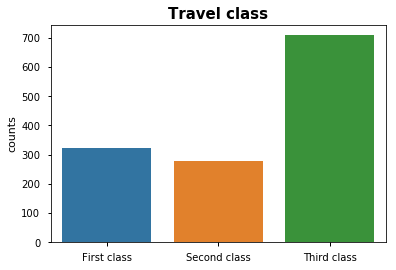

In [62]:
travel_class_counts = titanic_data.pclass.value_counts().sort_index()
travel_class_counts.index = ['First class', 'Second class', 'Third class']
travel_class_counts.columns = ['Travel class', 'counts']
bar_plot(travel_class_counts, 'Travel class')

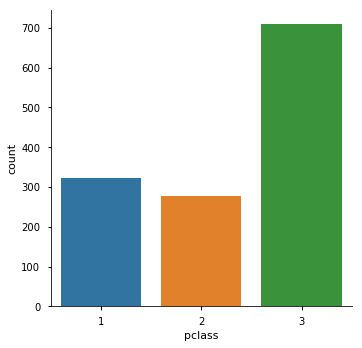

In [63]:
# seaborn one-liner
sns.factorplot(x='pclass', data=titanic_data, kind='count', size=5)

### Embarkation point bar plot 

For the embarkation point it makes sense to use again a bar plot because of the same reason as for the travel class, only here the values set is {S, C, Q}

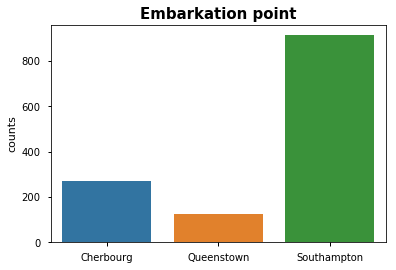

In [64]:
embarkation_port_counts = titanic_data.embarked.value_counts().sort_index()
embarkation_port_counts.index = ["Cherbourg", "Queenstown", "Southampton"]
bar_plot(embarkation_port_counts, 'Embarkation point')

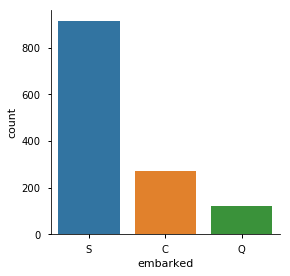

In [65]:
# seaborn one-liner
sns.factorplot(x='embarked', data=titanic_data, kind='count')

### Passengers sex bar plot

For the passengers sex is reasonable as well to us a bar plot given that we have only two values {female, male}

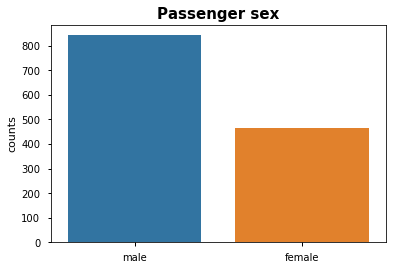

In [66]:
passengers_sex_counts = titanic_data.sex.value_counts()
bar_plot(passengers_sex_counts, 'Passenger sex')

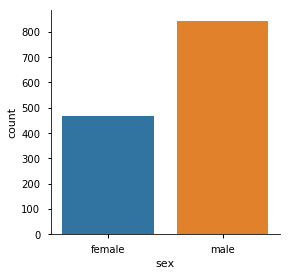

In [67]:
# seaborn one-liner
sns.factorplot('sex', data=titanic_data, kind='count')

### Passengers age histogram 

Given that we want to visualize the age in discrete decade intervals, meaning that multiple values will vote for the same bar, we will use a histogram. 


For this attribute we ignore the NaN values.

**Handling age values < 1**

We assume the age values smaller than 1 are actually months transformed in years. In order to check our assumption, firstly we multiple the values < 1 by 12 and we can see that the results are close to an integer value. Aditionally, we check whether the ticket number corresponds to another older passenger who might be a parent or relative.

In [68]:
# check if the transformation from years to months for the ages < 1 holds as valid
age_lower_1 = titanic_data[titanic_data.age < 1].copy()
age_lower_1['age_in_months'] = age_lower_1.age*12
age_lower_1

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,age_in_months
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",11.0004
359,2,1,"Caldwell, Master. Alden Gates",male,0.8333,0,2,248738,29.0000,NaN,S,13,NaN,"Bangkok, Thailand / Roseville, IL",9.9996
427,2,1,"Hamalainen, Master. Viljo",male,0.6667,1,1,250649,14.5000,NaN,S,4,NaN,"Detroit, MI",8.0004
548,2,1,"Richards, Master. George Sibley",male,0.8333,1,1,29106,18.7500,NaN,S,4,NaN,"Cornwall / Akron, OH",9.9996
590,2,1,"West, Miss. Barbara J",female,0.9167,1,2,C.A. 34651,27.7500,NaN,S,10,NaN,"Bournmouth, England",11.0004
611,3,1,"Aks, Master. Philip Frank",male,0.8333,0,1,392091,9.3500,NaN,S,11,NaN,"London, England Norfolk, VA",9.9996
657,3,1,"Baclini, Miss. Eugenie",female,0.7500,2,1,2666,19.2583,NaN,C,C,NaN,"Syria New York, NY",9.0000
658,3,1,"Baclini, Miss. Helene Barbara",female,0.7500,2,1,2666,19.2583,NaN,C,C,NaN,"Syria New York, NY",9.0000
747,3,0,"Danbom, Master. Gilbert Sigvard Emanuel",male,0.3333,0,2,347080,14.4000,NaN,S,NaN,NaN,"Stanton, IA",3.9996
763,3,1,"Dean, Miss. Elizabeth Gladys ""Millvina""",female,0.1667,1,2,C.A. 2315,20.5750,NaN,S,10,NaN,"Devon, England Wichita, KS",2.0004


In [69]:
# we check if for each of the passengers with age < 1 
# exists another passenger with the same ticket number
# but older
titanic_data.query('ticket in @age_lower_1.ticket').groupby('ticket').agg(max)

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked,body
ticket,,,,,,,,,,
113781,1,1,"Daniels, Miss. Sarah",male,33.0,1,2,151.5500,S,135.0
248738,2,1,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",male,26.0,1,2,29.0000,S,NaN
250649,2,1,"Hamalainen, Mrs. William (Anna)",male,24.0,1,2,14.5000,S,NaN
2625,3,1,"Thomas, Mrs. Alexander (Thamine ""Thelma"")",male,16.0,1,1,8.5167,C,NaN
2666,3,1,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,2,3,19.2583,C,NaN
29106,2,1,"Richards, Mrs. Sidney (Emily Hocking)",male,24.0,2,3,18.7500,S,NaN
347080,3,0,"Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria ...",male,34.0,1,2,14.4000,S,197.0
392091,3,1,"Aks, Mrs. Sam (Leah Rosen)",male,18.0,0,1,9.3500,S,NaN
C.A. 2315,3,1,"Dean, Mrs. Bertram (Eva Georgetta Light)",male,33.0,1,2,20.5750,S,NaN


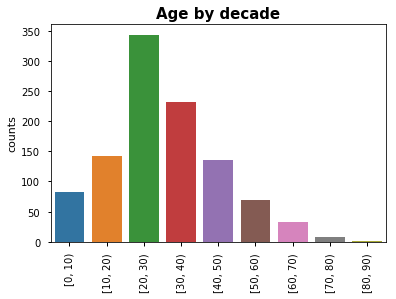

In [70]:
passengers_age = titanic_data.age[pd.notnull(titanic_data.age)]
age_by_decade = pd.cut(passengers_age, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], right=False).value_counts()
bar_plot(age_by_decade, 'Age by decade', labels_rotation_angle=90)

## Exercise 3 
Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

In order to do this, we must first determine the number of passengers per cabin floor. This number is not accurate with respect to reality given that not every passenger's data entry contains information about the cabin floor.

We assume that the decks were index by letters {A, B, C, D, E, F, G} https://www.encyclopedia-titanica.org/titanic-deckplans/.
We assume that the first character in the cabin column corresponds to the cabin's deck.

Cases that we take care of:
>Passengers with multiple cabins. Solution: we observe that the same multiple-cabins values correspond to multiple passengers. Given that we are interested in number of passengers per floor, we simply add one to the corresponding floor for each of them. The only problem could be that a passenger has cabins on multiple floors. So we check for these cases and find that there are not. Deck F has multiple sections with different identification letters as described lower so we do not consider them multiple floors.
>
>Cabin data with value T. Remark: There is only one cabin with this value and it corresponds to a cabin on Boat deck which is the most upper floor. This information can be found here http://www.titanic-titanic.com/titanic_cabin_t.shtml and the cabin also shows up in the blueprints here: https://www.encyclopedia-titanica.org/titanic-deckplans/boat-deck.html
>
>Cabin data with values that start with F correspond to the F-Deck which has several sections (as can be seen in the F-deck plan https://www.encyclopedia-titanica.org/titanic-deckplans/f-deck.html) like R, G, E, C, J, H, hence the values like "F G63" 

In [71]:
def check_multiple_floors(cabin_entry):
    cabins = cabin_entry.split(' ')
    # extract the deck letter
    for i in range(len(cabins)):
        cabins[i] = cabins[i][0]
    # verify if all values are equal
    return not(cabins[1:] == cabins[:-1])

for cabin_entry in titanic_data.cabin:
    if cabin_entry is not np.nan and (check_multiple_floors(cabin_entry)):
        if cabin_entry.startswith('F'):
            print("This format specifies a section of the F-deck:", cabin_entry)
        else:
            print(cabin_entry, ' has cabins on multiple floors')

This format specifies a section of the F-deck: F G63
This format specifies a section of the F-deck: F G63
This format specifies a section of the F-deck: F E57
This format specifies a section of the F-deck: F E46
This format specifies a section of the F-deck: F G73
This format specifies a section of the F-deck: F E69
This format specifies a section of the F-deck: F G73


In [72]:
# get a look at the values on F-deck
titanic_data[titanic_data.cabin.str[0] == 'F'].cabin

339        F4
340        F4
341        F4
342        F4
349       F33
380       F33
484       F33
514        F2
515        F2
516        F2
517        F2
521       F33
568         F
605     F G63
873     F G63
941     F E57
994     F E46
1024    F G73
1122    F E69
1217    F G73
1249      F38
Name: cabin, dtype: object

In [73]:
# check for seaborn or add legends and make it more readable
import matplotlib.pyplot as plt
'''
Simple function for pie charting
data: array-like
labels: list
'''
def pie_chart(data, labels, title, figsize=(5,5)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    pie_wedge_collection = ax.pie(data, labels=labels, labeldistance=1.05, autopct='%1.1f%%')
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
    ax.set_title(title, fontsize=15, fontweight='bold')

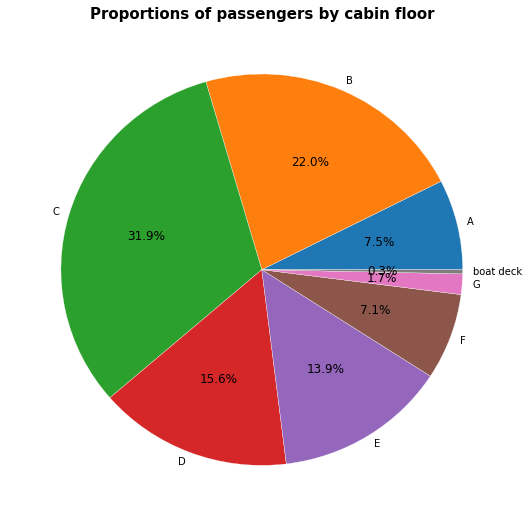

In [74]:
cabins_per_floor = titanic_data.cabin.str[0].value_counts().sort_index()
cabins_per_floor.index = np.r_[cabins_per_floor.index.values[:-1],(np.array(['boat deck']))]

piechart_title = "Proportions of passengers by cabin floor"
pie_chart(cabins_per_floor.values, cabins_per_floor.index, piechart_title, (9,9))

## Survival proportions by travel class

For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

In [75]:
# check if we have survival data for all passengers
titanic_data.survived.notnull().all()

True

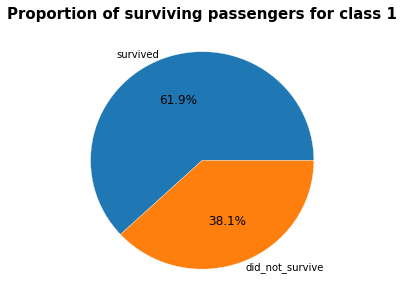

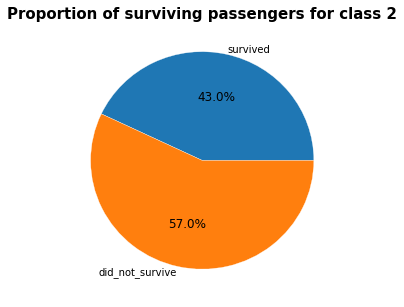

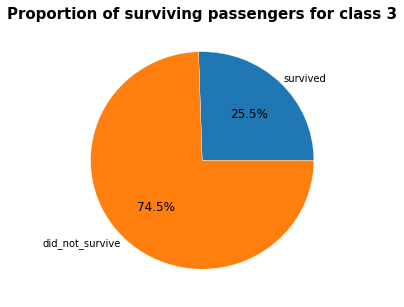

In [76]:
class_statistics = titanic_data.groupby(titanic_data.pclass)['survived'].agg(['sum', 'count'])
class_statistics['count'] = class_statistics['count'] - class_statistics['sum']
class_statistics.columns = ['survived', 'did_not_survive']
for i in range(len(class_statistics)):
    pie_chart(class_statistics.iloc[i], 
              class_statistics.columns, 
              'Proportion of surviving passengers for class {}'.format(i+1))

## Survival proportions by class and sex
Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.


In [77]:
# calculate the proportions grouping the date by class and sex, then aggregating over survived column
# using sum to get the number of surviving passengers and count to get the total number of passengers
class_sex_statistics = titanic_data.groupby(['pclass', 'sex'])['survived'].agg(['sum', 'count'])
class_sex_statistics.columns = ['survived', 'count']
class_sex_statistics['survival_rate'] = class_sex_statistics['survived']/class_sex_statistics['count']

In [78]:
statistics_reindexed = class_sex_statistics.reset_index()

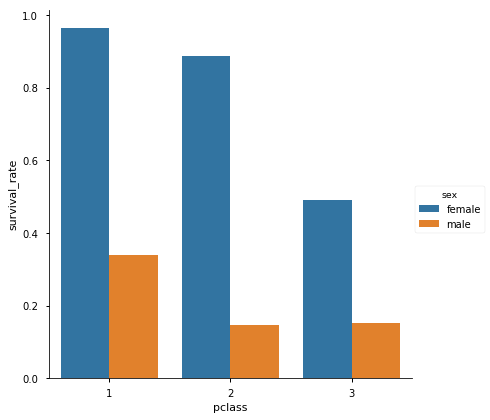

In [79]:
sns.factorplot(x='pclass', y='survival_rate', hue='sex',
               data=statistics_reindexed, kind='bar', size=6)

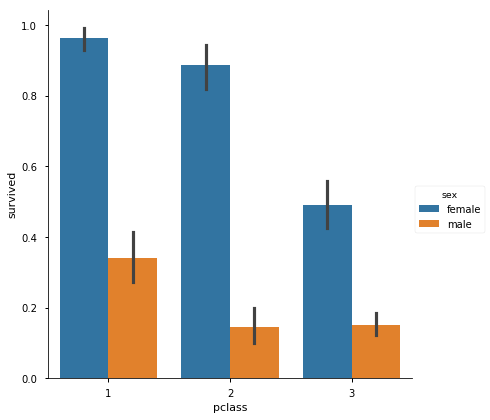

In [80]:
#seaborn one-liner
sns.factorplot(x="pclass", y="survived", hue="sex", data=titanic_data,
               size=6,kind="bar")

## Age categories
Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.



>For this task it was decided that the NaN values of the attribute age to be excluded.

To divide the data in two age categories we choose to use the **qcut** method because we can specify the number of quantiles and it simply does the job. One thing to notice is that the resulting categories do not have exactly the same number of elements. But we want the resulting DataFrame to have meaningful information, therefore we choose the categories to be meaningful (to respect some rule according to which they are splitted in two almost-equally populated groups)

We exclude the NaN values from the age category creating a new DataFrame

In [81]:
titanic_clean_age = titanic_data[pd.notnull(titanic_data.age)].copy()
titanic_clean_age.reset_index(inplace=True)

Apply the qcut function to obtain two categories split over the median value

In [82]:
categ = pd.qcut(titanic_clean_age.age, 2)

Create a new column in the DataFrame corresponding to the row's category so that we can groupby it

In [83]:
titanic_clean_age['age_cat'] = categ

We group the data by age category, class and sex, in this order. Then we aggregate the survived values to optain the proportions corresponding to the given classes.

In [84]:
cat_stats = titanic_clean_age.groupby(['age_cat', 'pclass', 'sex'])['survived'].agg(['sum','count'])
cat_stats.columns=['survived', 'total']
cat_stats['proportions'] = cat_stats['survived']/cat_stats['total']

In [85]:
cat_stats

survived  total  proportions
age_cat       pclass sex                                 
(0.166, 28.0] 1      female        39     41     0.951220
                     male          17     32     0.531250
              2      female        51     56     0.910714
                     male          16     74     0.216216
              3      female        56    109     0.513761
                     male          41    224     0.183036
(28.0, 80.0]  1      female        89     92     0.967391
                     male          36    119     0.302521
              2      female        41     47     0.872340
                     male           7     84     0.083333
              3      female        16     43     0.372093
                     male          18    125     0.144000

Finally we check if the index is unique

In [86]:
cat_stats.index.is_unique

True

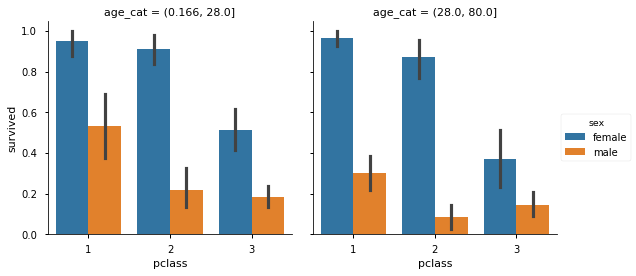

In [87]:
sns.factorplot(x='pclass', y='survived', hue='sex', data=titanic_clean_age, kind='bar', col='age_cat')